# Topical Analysis - Visualizations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


chunk_predictions = pd.read_csv("chunk_predictions.csv")
chunk_predictions = chunk_predictions.drop("Text", axis=1)
results_df = chunk_predictions

# Want to aggregate by month instead of quarter

# Step 1: Extract Year and Report Number
results_df["Year"] = results_df["Filename"].str.extract(r"(\d{4})").astype(int)
results_df["Report_Number"] = results_df["Filename"].str.extract(r"\((\d+)\)").astype(int)

# Step 2: Map Report Numbers to Months
    # Got months from Fed website and put them in a spreadsheet
    # See C:\Users\MCOB PHD 14\Desktop\bbFinal\Notebooks\BB_publication_months.xlsx
def get_month(year, report_number):
    # Define mappings for report numbers to months
    if 1970 <= year <= 1978:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "06", 8: "05", 9: "04", 
                         10: "03", 11: "02", 12: "01"}
    elif year == 1979:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "07", 6: "05", 7: "04", 8: "03", 9: "01"}
    elif year == 1980:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "05", 8: "04", 9: "03", 10: "01"}
    elif year in {1981, 2017, 2023}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year == 2012:
        month_mapping = {1: "11", 2: "10", 3: "08", 4: "07", 5: "06", 6: "04", 7: "02", 8: "01"}
    elif year in {2018, 2020, 2024}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year in {2002, 2003, 2005, 2006, 2007, 2011, 2016, 2019, 2022}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {2004, 2008, 2009, 2010, 2013, 2014, 2015, 2021}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {1988, 2001}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    elif year == 1983:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "07", 6: "05", 7: "03", 8: "02"}
    elif year in {1984, 1985, 1986, 1987, 1990, 1991, 1996, 1997}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    else:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    return month_mapping.get(report_number, "Unknown")

results_df["Month"] = results_df.apply(lambda row: get_month(row["Year"], row["Report_Number"]), axis=1)

# Step 3: Convert Year and Month to Date-Time Format
results_df["DATE"] = results_df.apply(lambda row: f"{row['Year']}-{row['Month']}-01", axis=1)
results_df["DATE"] = pd.to_datetime(results_df["DATE"], errors="coerce")

# Step 4: Aggregate Data by Month
topic_columns_original = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

aggregated_df = results_df.groupby("DATE")[topic_columns_original].sum().reset_index()

# Export to csv
#aggregated_df.to_csv("aggregated_predictions_monthly.csv", index=False)

df = aggregated_df
df['DATE'] = pd.to_datetime(df['DATE'])

# Create dummy variable for dates of recessions
    # Dates defined by Business Cycle Dating Committee of the NBER
df["Recession"] = 0
df.loc[(df["DATE"] >= "1969-12-01") & (df["DATE"] <= "1970-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1973-11-01") & (df["DATE"] <= "1975-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1980-01-01") & (df["DATE"] <= "1980-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1981-07-01") & (df["DATE"] <= "1982-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1990-07-01") & (df["DATE"] <= "1991-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2001-03-01") & (df["DATE"] <= "2001-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2007-12-01") & (df["DATE"] <= "2009-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2020-02-01") & (df["DATE"] <= "2020-04-01"), "Recession"] = 1

topic_columns = ["Employment", "Prices", "Manufacturing", "Construction",
                 "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

# Now

# Define X as including all the topic columns
X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model_now = sm.Probit(y, X).fit()

# Save predictions to df
df["Recession_Probability_Nowcast"] = model_now.predict(X)

marginal_effects_now = model_now.get_margeff()

# Create lags of dependent variable

# Create a three-month lag of the Recession dummy variable
df['Recession_lag_3'] = df['Recession'].shift(-3)

# Create a six-month lag of the Recession dummy variable
df['Recession_lag_6'] = df['Recession'].shift(-6)


# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lag_6"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the six-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_6']

# Fit the model with a logistic regression
model_lag_6 = sm.Probit(y, X).fit()

df["Recession_Probability_lag_6"] = model_lag_6.predict(X)
df["Recession_lag_6"] = y
marginal_effects_lag_6 = model_lag_6.get_margeff()

# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lag_3"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_3']

# Fit the model with a logistic regression
model_lag_3 = sm.Probit(y, X).fit()

df["Recession_Probability_lag_3"] = model_lag_3.predict(X)
df["Recession_lag_3"] = y
marginal_effects_lag_3 = model_lag_3.get_margeff()

# Create a three-period lead of the Recession dummy variable
df['Recession_lead_3'] = df['Recession'].shift(3)

# Create a six-period lead of the Recession dummy variable
df['Recession_lead_6'] = df['Recession'].shift(6)

# Create an eight-period lead of the Recession dummy variable
    # In Beige Books, this is a year ahead
df['Recession_lead_8'] = df['Recession'].shift(8)

# Create 16-period lead of the Recession dummy variable
    # In Beige Books, this is two years ahead
df['Recession_lead_16'] = df['Recession'].shift(16) 


# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_3"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_3']

# Fit the model with a logistic regression
model_lead_3 = sm.Probit(y, X).fit()

df["Recession_Probability_lead_3"] = model_lead_3.predict(X)
df["Recession_lead_3"] = y
marginal_effects_lead_3 = model_lead_3.get_margeff()

# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_6"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_6']

# Fit the model with a logistic regression
model_lead_6 = sm.Probit(y, X).fit()

df["Recession_Probability_lead_6"] = model_lead_6.predict(X)
df["Recession_lead_6"] = y
marginal_effects_lead_6 = model_lead_6.get_margeff()

# This uses an 8-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_8"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_8']

# Fit the model with a logistic regression
model_lead_8 = sm.Probit(y, X).fit()

df["Recession_Probability_lead_8"] = model_lead_8.predict(X)
df["Recession_lead_8"] = y

marginal_effects_lead_8 = model_lead_8.get_margeff()

# This uses an 16-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_16"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_16']

# Fit the model with a logistic regression
model_lead_16 = sm.Probit(y, X).fit()

df["Recession_Probability_lead_16"] = model_lead_16.predict(X)
df["Recession_lead_16"] = y
marginal_effects_lead_16 = model_lead_16.get_margeff()


Optimization terminated successfully.
         Current function value: 0.207249
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.323731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208456
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.280855
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.323607
         Iterations 7


# Visualizations

## Probability of recession over time

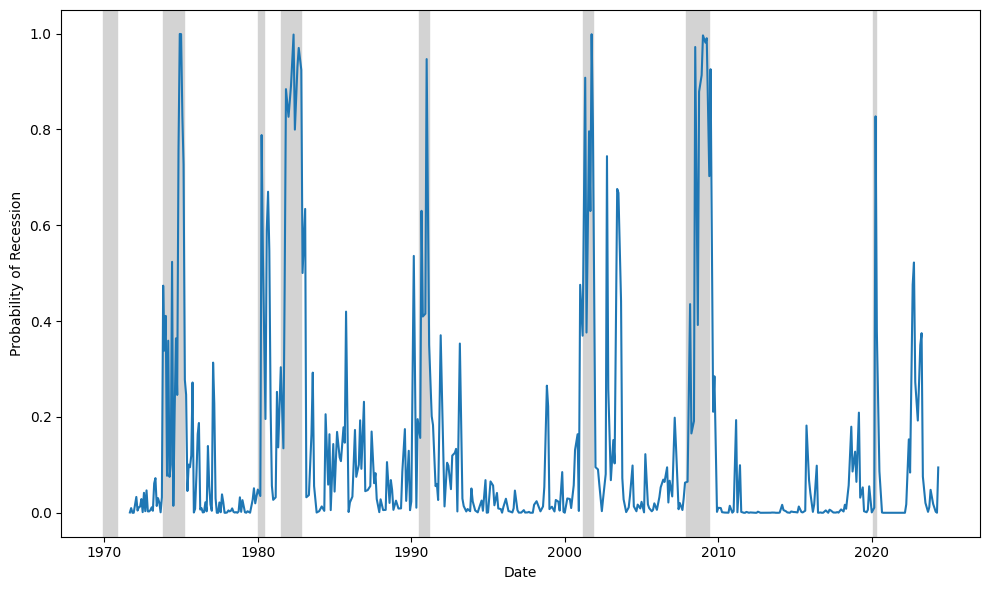

In [9]:
# This recreates Figure 2 from Filippou et al. (2024)
    # Clearly, sentiment from Beige Books is useful for predicting recessions
    # But also want to do this with the leads to see probability of a recession 3 mohths and 6 months out

# Calculate probabilities from the logit model above
df['Recession_probability'] = model_now.predict(X)

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Recession_probability'])
plt.xlabel('Date')
plt.ylabel('Probability of Recession')

# Add recession bars
plt.axvspan("1969-12-01", "1970-11-01", color='lightgray', alpha=1)
plt.axvspan("1973-11-01", "1975-03-01", color='lightgray', alpha=1 )
plt.axvspan("1980-01-01", "1980-06-01", color='lightgray', alpha=1)
plt.axvspan("1981-07-01", "1982-11-01", color='lightgray', alpha=1)
plt.axvspan("1990-07-01", "1991-03-01", color='lightgray', alpha=1)
plt.axvspan("2001-03-01", "2001-11-01", color='lightgray', alpha=1)
plt.axvspan("2007-12-01", "2009-06-01", color='lightgray', alpha=1)
plt.axvspan("2020-02-01", "2020-04-01", color='lightgray', alpha=1)

plt.tight_layout()
plt.savefig('recession_probability.png')

plt.show()

## Heatmap of topic mentions

C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_8012\1299858393.py:13: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



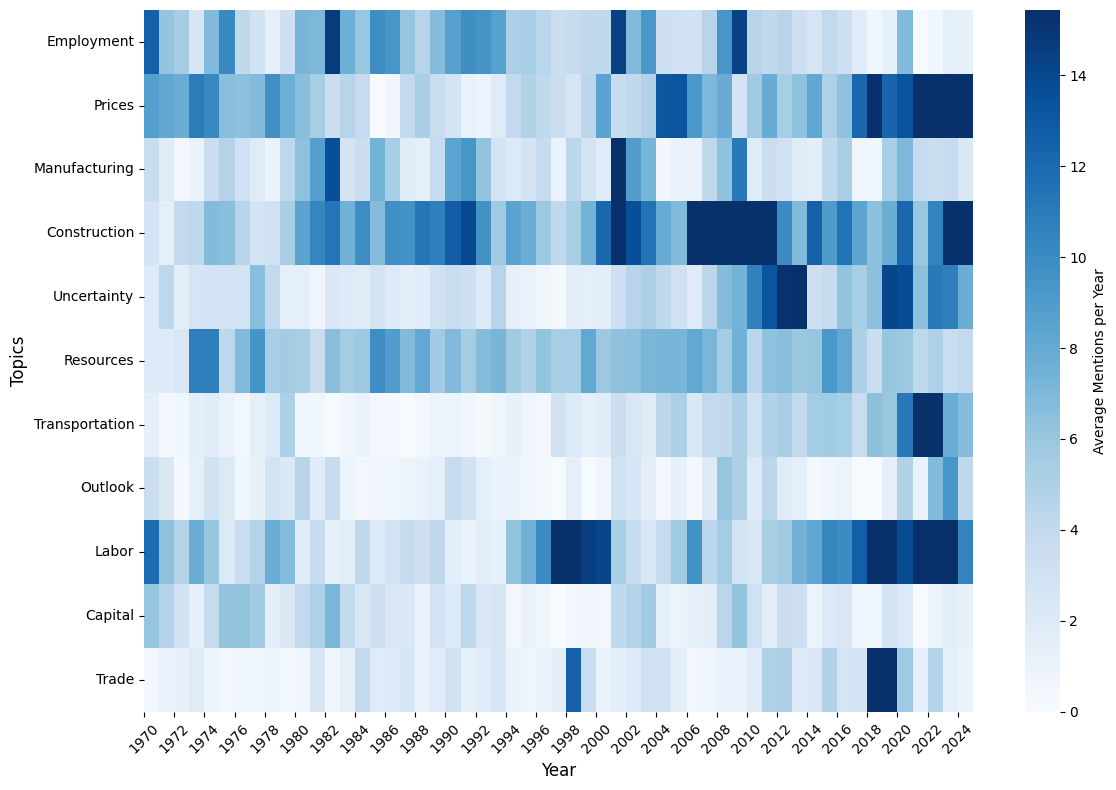

In [10]:
# Create a copy of df to avoid modifying the original dataframe
df_temp = df.copy()

# Select the topic columns
topic_columns = ["Employment", "Prices", "Manufacturing", "Construction",
                 "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

# Temporarily set the 'DATE' column as the index in the copied dataframe
df_temp.set_index('DATE', inplace=True)

# Resample the data to annual frequency and calculate the average mentions per year for topic columns
df_annual_avg = df_temp[topic_columns].resample('Y').mean()

# Set the color scale limits to focus on lower values (adjust min/max if needed)
vmin, vmax = 0, df_annual_avg.max().max() * 0.5  # Half of the global maximum for better lower-value variation

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_annual_avg.transpose(), cmap="Blues", annot=False, cbar_kws={'label': 'Average Mentions per Year'}, vmin=vmin, vmax=vmax)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Topics', fontsize=12)

# Format the x-axis to show every other year
plt.xticks(ticks=range(0, len(df_annual_avg.index), 2), 
           labels=df_annual_avg.index.year[::2], rotation=45)

plt.tight_layout()

plt.savefig('heatmap_topics.png')
plt.show()

## ROC Curves for probit models

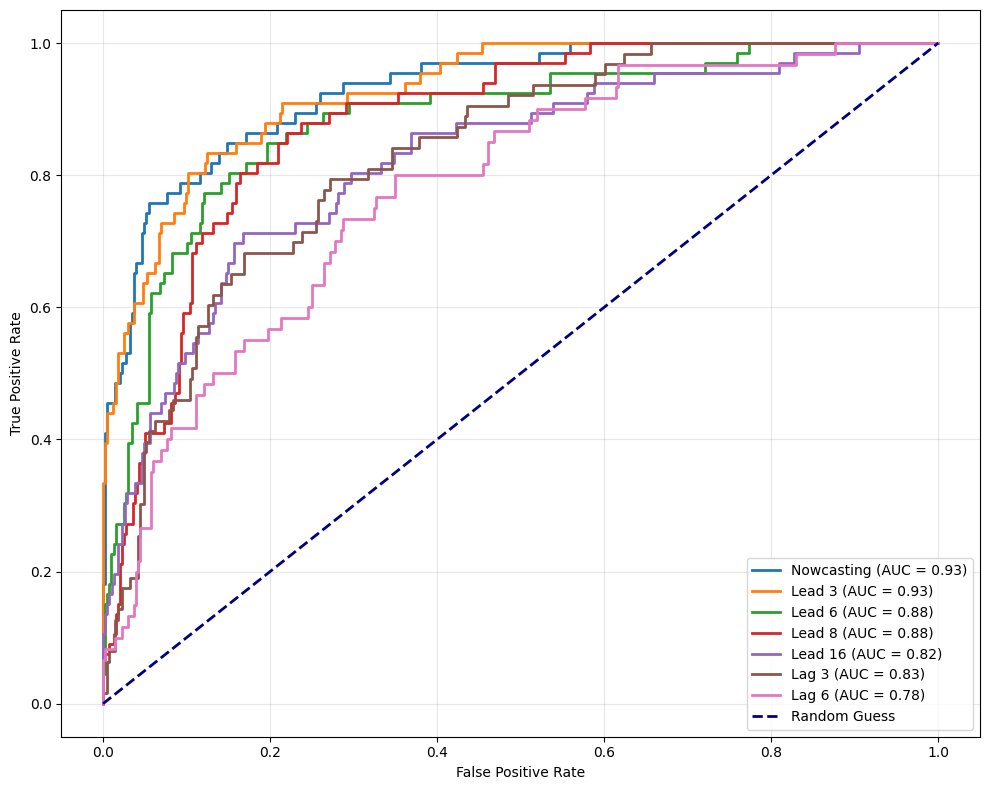

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# Define the saved columns for each model
models_info = {
    "Nowcasting": {"y_true": "Recession", "y_pred": "Recession_Probability_Nowcast"},
    "Lead 3": {"y_true": "Recession_lead_3", "y_pred": "Recession_Probability_lead_3"},
    "Lead 6": {"y_true": "Recession_lead_6", "y_pred": "Recession_Probability_lead_6"},
    "Lead 8": {"y_true": "Recession_lead_8", "y_pred": "Recession_Probability_lead_8"},
    "Lead 16": {"y_true": "Recession_lead_16", "y_pred": "Recession_Probability_lead_16"},
    "Lag 3": {"y_true": "Recession_lag_3", "y_pred": "Recession_Probability_lag_3"},
    "Lag 6": {"y_true": "Recession_lag_6", "y_pred": "Recession_Probability_lag_6"},
}

plt.figure(figsize=(10, 8))


# Loop through each model to calculate and plot ROC curve
for label, cols in models_info.items():
    y_true = df[cols["y_true"]]
    y_pred = df[cols["y_pred"]]
    
    # Remove NaNs in y_true and y_pred
    valid_rows = ~(y_true.isna() | y_pred.isna())
    y_true = y_true[valid_rows]
    y_pred = y_pred[valid_rows]
    
    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

# Plot the random-guess line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")

# Finalize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_probit.png')
plt.show()


## Marginal effects by topic

C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_8012\603717619.py:16: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



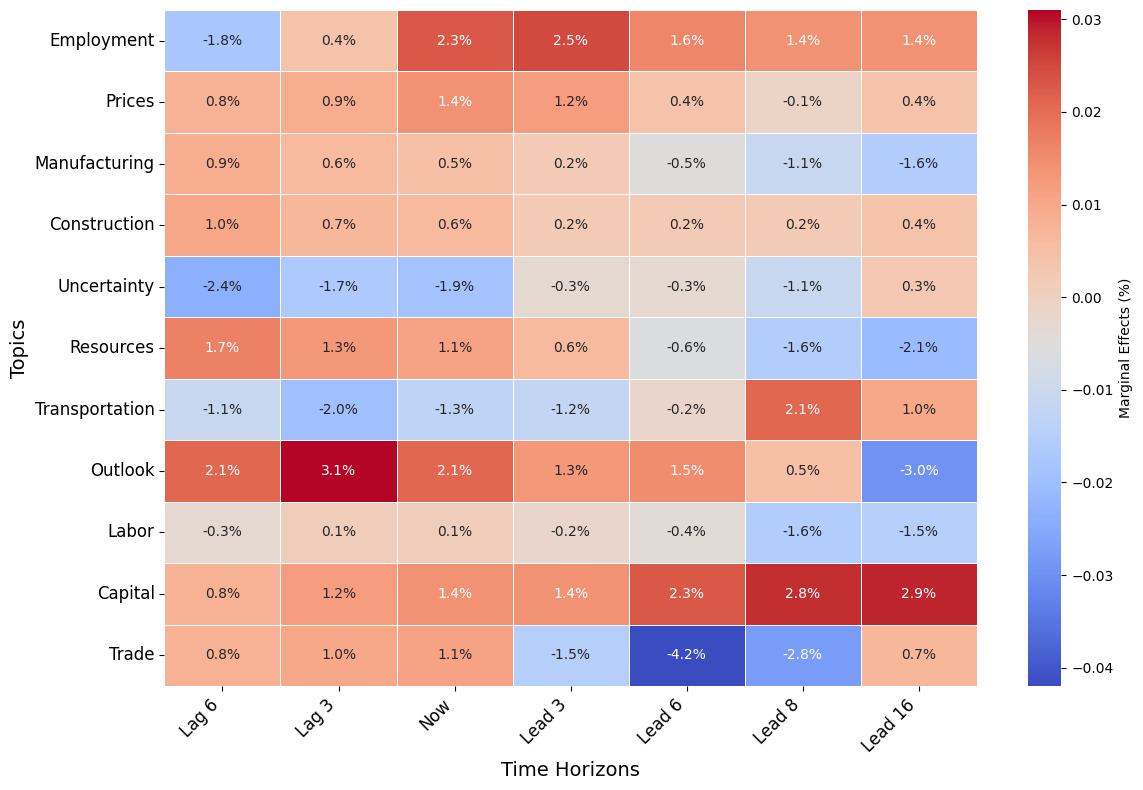

In [12]:
# Create a DataFrame to store the marginal effects
# Extract variable names (topics) from one of the models
variable_names = [name for name in model_lag_6.model.exog_names if name.lower() != 'const']

marginal_effects_df = pd.DataFrame({
    'Lag 6': marginal_effects_lag_6.margeff.round(3),
    'Lag 3': marginal_effects_lag_3.margeff.round(3),
    'Now': marginal_effects_now.margeff.round(3),
    'Lead 3': marginal_effects_lead_3.margeff.round(3),
    'Lead 6': marginal_effects_lead_6.margeff.round(3),
    'Lead 8': marginal_effects_lead_8.margeff.round(3),
    'Lead 16': marginal_effects_lead_16.margeff.round(3)
}, index=variable_names)

# Format marginal effects as percentages for display
formatted_df = marginal_effects_df.applymap(lambda x: f"{x*100:.1f}%")

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    marginal_effects_df,  # Use the original data for the color scale
    annot=formatted_df,  # Use the formatted percentages for annotations
    fmt="s",  # String format since annotations are now strings
    cmap="coolwarm",  # Adjust color palette as desired
    cbar_kws={'label': 'Marginal Effects (%)'},
    linewidths=0.5
)

# Add labels and title
plt.xlabel("Time Horizons", fontsize=14)
plt.ylabel("Topics", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('marginal_effects.png')
plt.show()


## Boxplot of topic mentions

C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_8012\2791858519.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




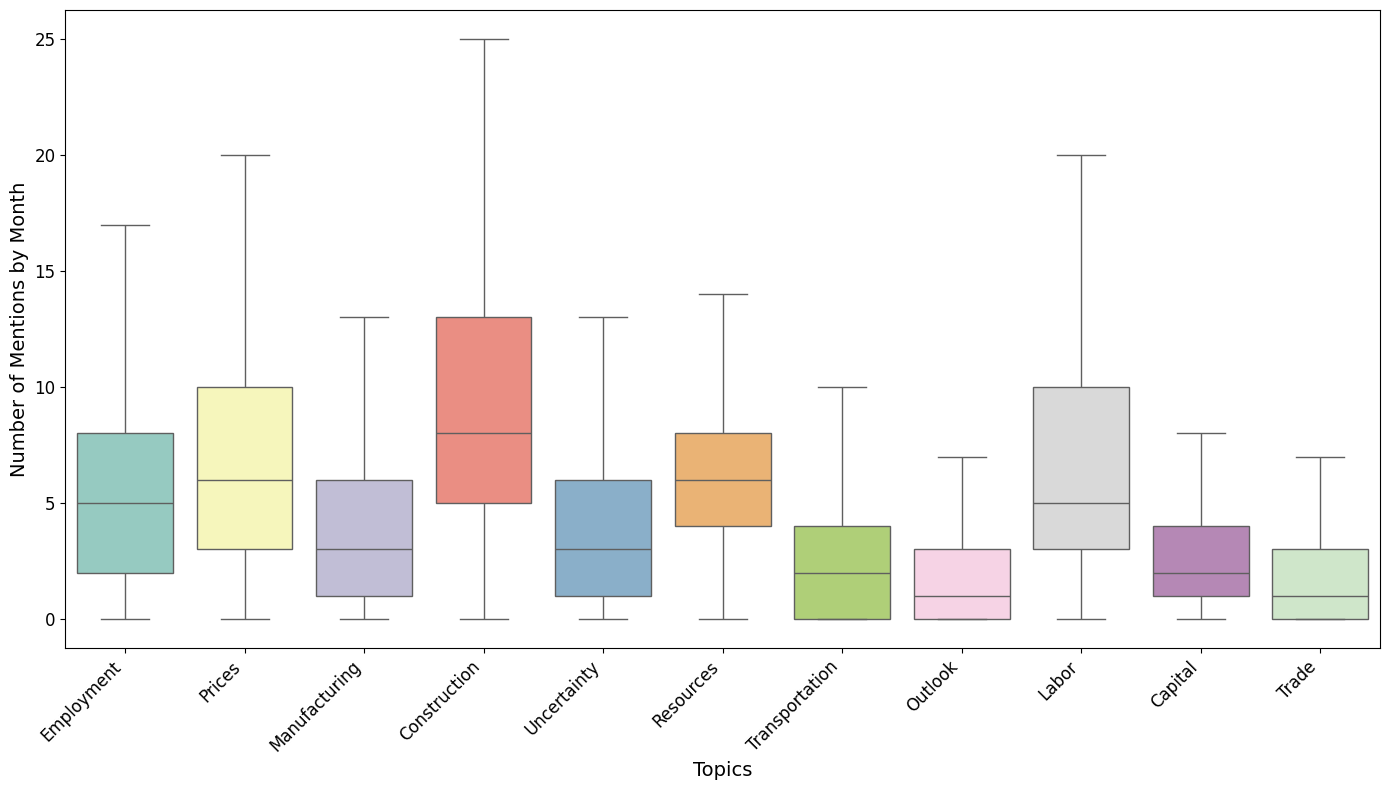

In [13]:
# Select only topic_columns into topics_df
topics_df = df[topic_columns + ['DATE']]
# Melt the dataframe to long format for Seaborn
topics_long = topics_df.melt(id_vars='DATE', var_name='Topic', value_name='Mentions')

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=topics_long,
    x='Topic',
    y='Mentions',
    palette="Set3",
    showfliers=False  # Optionally hide outliers for cleaner visualization
)

# Add labels, title, and adjust x-axis
plt.xlabel('Topics', fontsize=14)
plt.ylabel('Number of Mentions by Month', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()
plt.savefig('boxplot_topics.png')
plt.show()

## R-squared column chart

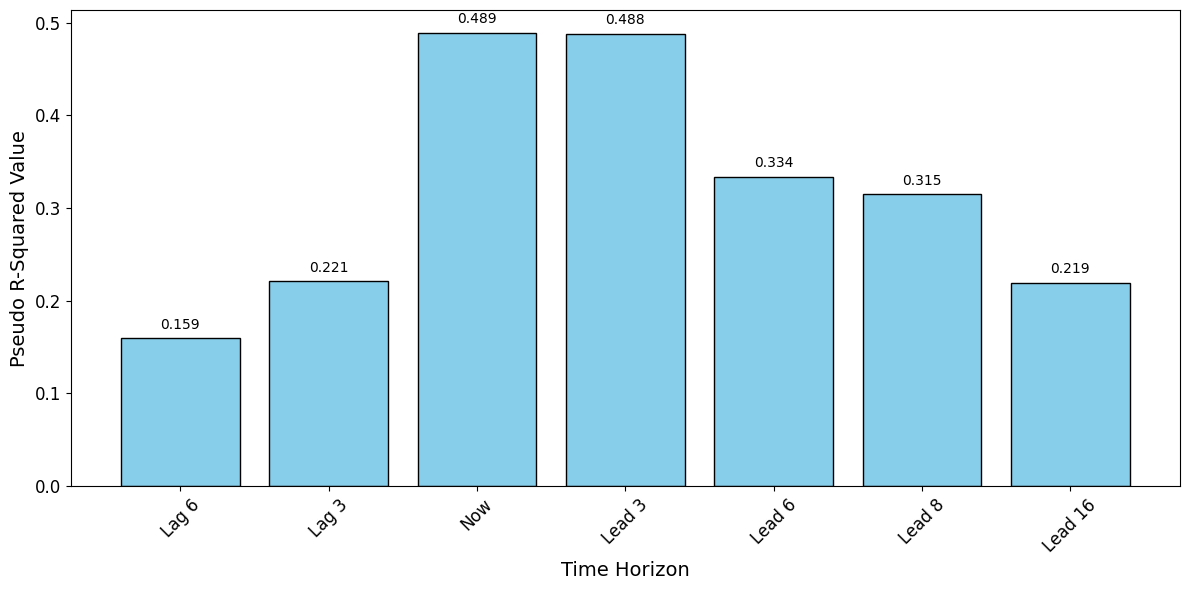

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Pull in the pseudo R-squared values from the actual models
# Each should have this stored within it
models = {'Lag 6': model_lag_6, 'Lag 3': model_lag_3, 'Now': model_now, 'Lead 3': model_lead_3, 'Lead 6': model_lead_6, 'Lead 8': model_lead_8, 'Lead 16': model_lead_16}

# Extract the pseudo R-squared values from each model
pseudo_r_squared = {name: model.prsquared for name, model in models.items()}

# Convert to DataFrame for easier plotting
pseudo_df = pd.DataFrame(list(pseudo_r_squared.items()), columns=['Time Horizon', 'Pseudo R-Squared'])

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(pseudo_df['Time Horizon'], pseudo_df['Pseudo R-Squared'], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Time Horizon', fontsize=14)
plt.ylabel('Pseudo R-Squared Value', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Annotate bar values
for i, value in enumerate(pseudo_df['Pseudo R-Squared']):
    plt.text(i, value + 0.01, f"{value:.3f}", ha='center', fontsize=10)

# Display the chart
plt.tight_layout()
plt.savefig('pseudo_r_squared.png')
plt.show()


## Ridgeplot of topic mentions

In [20]:
import numpy as np
from ridgeplot import ridgeplot
import pandas as pd
import plotly.io as pio  # Import Plotly's I/O module

# Create a list of topic names
topics = topic_columns  # Use the previously defined list of topics

# Transform the data into a 3D array format with samples per topic
samples = [
    df[topic].dropna() for topic in topics  # Drop NaN values for each topic
]

# Generate the ridge plot
fig = ridgeplot(
    samples=samples,
    labels=topics,  # Use the topic names as labels
    colorscale="portland",  # Choose a colorscale
    bandwidth=1.0,  # Adjust bandwidth for smoother KDE
    kde_points=np.linspace(0, df[topics].max().max(), 500),  # Adjust KDE range
    spacing=0.4,  # Adjust spacing between ridges
)

# Customize the layout
fig.update_layout(
    height=800,
    width=1000,
    font_size=14,
    plot_bgcolor="rgb(245, 245, 245)",
    xaxis_gridcolor="white",
    yaxis_gridcolor="white",
    xaxis_gridwidth=2,
    yaxis_title="Topics",
    xaxis_title="Number of Mentions in a Month",
    showlegend=False,
    xaxis_range=[0, 20], # Limit X-axis to a maximum of 20 mentions
    margin=dict(l=50, r=50, t=20, b=50),  # Set smaller top margin  
)

# Save as an HTML file to view in a browser (optional)
fig.write_html("ridgeplot.html")

# Show the plot
fig.show()
